# Demo

This notebook is a demonstration of how to use FRESCO to score molecules. It is recommended to run this notebook in a conda environment created from the `environment.yml` file in the root directory of the repo.

# Load fragment complexes

In [ ]:
import pickle
from rdkit import Chem
from os import listdir

mpro_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/Mpro'

frags = pickle.load(open(mpro_dir + '/frags_mpro.pickle', 'rb'))

frag_mols = []
for mol in frags:
    m = Chem.RemoveHs(mol[0])
    frag_mols.append(m, confId=-1)

filenames = [ f for f in listdir('../../data/Mpro/frags/') if f[-5:]=='0.pdb']
df = pd.read_csv('../../data/Mpro/frags/hits_summary.csv')
df['smiles'] = [Chem.MolToSmiles(Chem.MolFromSmiles(smi)) for smi in df['Compound SMILES']]
df.query('smiles.isin(@frag_list)')

w = Chem.SDWriter("mpro_frags.sdf")
for m in frag_mols:
    mpro_id = df.query('smiles == @Chem.MolToSmiles(m)')['Dataset'].values[0]
    m.SetProp("name", mpro_id) # this is a specific value which is different per conformer
    w.write(m)
w.close()

In [1]:
import pandas as pd
from rdkit.Chem import PandasTools

sdfFile = '../../data/mpro_frags.sdf'
df_fragments = PandasTools.LoadSDF(sdfFile, idName='name', smilesName='SMILES', molColName='mol')

#TODO - dump Mpro and Mac1 crystal info into data folders
#TODO - just save an sdf of the mpro fragments for simple loading

INFO:rdkit:Enabling RDKit 2022.03.1 jupyter extensions


# Featurise into pharmacophores

In [ ]:
from fresco.featurise import return_pcore_dataframe_for_list_of_mols, calculate_frequency_weights_for_duplicate_fragments

pcore_df = return_pcore_dataframe_for_list_of_mols(df_fragments['mol'].values)

Calculate pharmacophore distance histogram and weight histograms

In [ ]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble

interesting_pcores = return_default_pharmacophore_pairs()
frag_pcore_histogram = {}
frag_pcore_weight = {}
for pcore_pair in interesting_pcores:
    core_a,core_b = pcore_pair.split('-')
    frag_pcore_histogram[pcore_pair], frag_pcore_weight[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_fragment_ensemble(pcore_df, core_a, core_b)

# Fit FRESCO model

,index,canonical_CID,SMILES,mol,series,Chemgauss4 Score,f_avg_pIC50,f_avg_IC50,chloroacetamide,acrylamide,Number of Confs,r_inhibition_at_50_uM,r_avg_IC50,relative_solubility_at_100_uM,relative_solubility_at_20_uM,f_inhibition_at_50_uM,f_inhibition_at_20_uM,r_inhibition_at_20_uM,trypsin_IC50,frag_id
0,1,EDG-MED-ba1ac7b9-15,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,,3-aminopyridine-like,-12.6986,5.20921,6.17716,False,False,38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2,MAT-POS-9ff17035-2,O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2cc...,,3-aminopyridine-like,-12.43,5.70429,1.97563,False,False,500,41.805,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3,EDJ-MED-8c98ee63-2,Cn1ccc(CNC[C@@]2(C(=O)Nc3cncc4ccccc34)CCOc3ccc...,,3-aminopyridine-like,-12.3919,6.09539,0.802811,False,False,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,4,ALP-POS-64a710fa-1,O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1,,NaN,-12.3789,5.00607,9.86113,False,False,500,NaN,3.02151,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5,BAR-COM-4e090d3a-3,Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1,,3-aminopyridine-like,-12.3516,NaN,NaN,False,False,500,35.735,NaN,0.94,0.95,7.28047,-0.0560025,4.5875,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,2654,ALP-POS-305f6ec3-52,CC(C)(C)c1ccc(N(C(=O)c2c[nH]c(=O)[nH]2)[C@@H](...,,Ugi,3.0553,4.79812,15.9178,False,False,74,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2534,2655,ALP-POS-88a7a97e-23,COC(=O)[C@@H]1C[C@@H](NC(=O)[C@H](c2cccnc2)N(C...,,NaN,3.38598,5.16595,6.82414,False,False,106,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2535,2656,ALP-POS-b0bc6a46-27,N#Cc1cc(N(C(=O)c2ccco2)[C@@H](C(=O)NCCc2cccc(F...,,NaN,3.53119,NaN,99.5,False,False,500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2536,2657,BRU-THA-92256091-77,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1c[n...,,NaN,4.22059,4.32089,47.765,False,False,44,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN

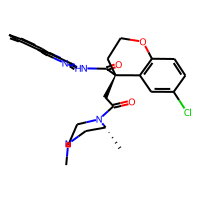
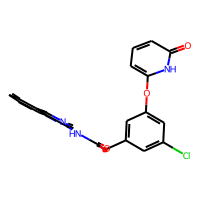
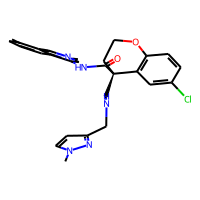
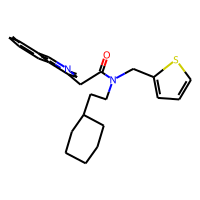
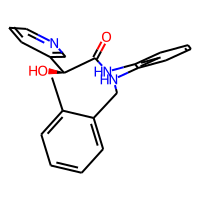
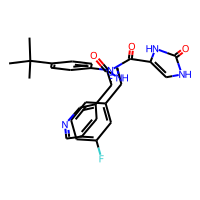
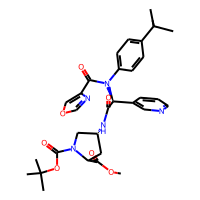
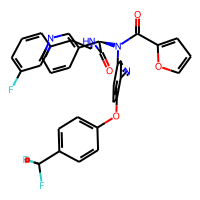
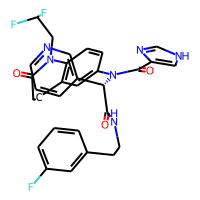
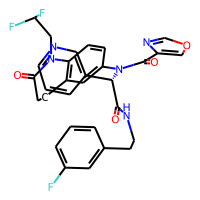

In [2]:
from fresco.model import fit_pair_kde

kde = fit_pair_kde(frag_pcore_histogram, frag_pcore_weight, interesting_pcores)

# Use FRESCO to score a molecule

In [3]:
from fresco.featurise import return_pcore_dataframe_from_single_rdkit_molecule

smiles = 'Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1'
mol = Chem.MolFromSmiles(smiles)

mol_pcore_df = return_pcore_dataframe_from_single_rdkit_molecule(mol)


100%|██████████| 2538/2538 [00:38<00:00, 65.82it/s]


,pcore,smiles,mol_id,coord_x,coord_y,coord_z
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,8.706100,-3.282500,24.817800
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,6.785400,-4.799400,26.467600
0,Donor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,7.780500,-0.126000,21.171800
0,Acceptor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,6.594600,0.190600,17.701700
0,Acceptor,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,0,9.923300,0.106100,20.227800
...,...,...,...,...,...,...
0,Acceptor,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,5.232900,-7.223200,27.364600
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,11.660640,0.511120,24.741700
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,6.833800,-5.037117,27.731300
0,Aromatic,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1coc...,2537,5.819533,-0.802667,24.718817


Generate pharmacophore 2-body distribution

In [4]:
from fresco.featurise import return_default_pharmacophore_pairs, calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand

pcore_pairs = return_default_pharmacophore_pairs()

pair_distribution_for_this_ligand = {}
    
for pcore_pair in pcore_pairs:
    core_a,core_b = pcore_pair.split('-')
    pair_distribution_for_this_ligand[pcore_pair] = calculate_pairwise_distances_between_pharmacophores_for_a_single_ligand(
        mol_pcore_df, core_a, core_b)

100%|██████████| 2538/2538 [01:29<00:00, 28.49it/s]


Load FRESCO model

In [5]:
import dill as pickle
from fresco.model import load_kde_model

pickle_dir = '/home/wjm41/ml_physics/frag-pcore-screen/data/EnamineREAL/pickles/'
xray_kde_mpro = 'kde_dict_spl_mpro.pickle'
xray_kde_dict = pickle.load(open(pickle_dir+xray_kde_mpro, 'rb'))


Score the molecule with the KDE!

,index,canonical_CID,SMILES,mol,series,Chemgauss4 Score,f_avg_pIC50,f_avg_IC50,chloroacetamide,acrylamide,...,f_inhibition_at_20_uM,r_inhibition_at_20_uM,trypsin_IC50,frag_id,xray_fresco_score,random_fresco_score,docked_fresco_score,docked_5_fresco_score,docked_dsi_fresco_score,docked_dsi_filtered_fresco_score
0,1,EDG-MED-ba1ac7b9-15,C[C@@H]1CN(C)CCN1C(=O)C[C@@]1(C(=O)Nc2cncc3ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.6986,5.20921,6.17716,False,False,...,NaN,NaN,NaN,NaN,-1.956048,-1.568535,-1.927443,-1.879116,-1.815833,-1.686966
1,2,MAT-POS-9ff17035-2,O=C(Cc1cc(Cl)cc(Oc2cccc(=O)[nH]2)c1)Nc1cncc2cc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.43,5.70429,1.97563,False,False,...,NaN,NaN,NaN,NaN,-1.955927,-1.820553,-1.971900,-2.001098,-1.956925,-1.935686
2,3,EDJ-MED-8c98ee63-2,Cn1ccc(CNC[C@@]2(C(=O)Nc3cncc4ccccc34)CCOc3ccc...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.3919,6.09539,0.802811,False,False,...,NaN,NaN,NaN,NaN,-1.987350,-1.671622,-1.859249,-1.848437,-1.826173,-1.716879
3,4,ALP-POS-64a710fa-1,O=C(Cc1cncc2ccccc12)N(CCC1CCCCC1)Cc1cccs1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,-12.3789,5.00607,9.86113,False,False,...,NaN,NaN,NaN,NaN,-2.639950,-2.420212,-2.545335,-2.744855,-2.760389,-2.393283
4,5,BAR-COM-4e090d3a-3,Cc1ccccc1CNc1ccccc1NC(=O)[C@@H](O)c1cccnc1,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",3-aminopyridine-like,-12.3516,NaN,NaN,False,False,...,-0.0560025,4.5875,NaN,NaN,-2.095374,-1.733485,-1.852797,-1.915045,-1.796295,-1.674696
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2533,2654,ALP-POS-305f6ec3-52,CC(C)(C)c1ccc(N(C(=O)c2c[nH]c(=O)[nH]2)[C@@H](...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",Ugi,3.0553,4.79812,15.9178,False,False,...,NaN,NaN,NaN,NaN,-1.978760,-1.646912,-1.818253,-1.845265,-1.802240,-1.689190
2534,2655,ALP-POS-88a7a97e-23,COC(=O)[C@@H]1C[C@@H](NC(=O)[C@H](c2cccnc2)N(C...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,3.38598,5.16595,6.82414,False,False,...,NaN,NaN,NaN,NaN,-2.149193,-1.696592,-1.844638,-1.836213,-1.835609,-1.771977
2535,2656,ALP-POS-b0bc6a46-27,N#Cc1cc(N(C(=O)c2ccco2)[C@@H](C(=O)NCCc2cccc(F...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,3.53119,NaN,99.5,False,False,...,NaN,NaN,NaN,NaN,-2.488512,-2.409595,-2.402487,-2.710506,-2.712887,-2.424056
2536,2657,BRU-THA-92256091-77,O=C(NCCc1cccc(F)c1)[C@H](c1cccnc1)N(C(=O)c1c[n...,"<img data-content=""rdkit/molecule"" src="""" alt=""Mol""/>",NaN,4.22059,4.32089,47.765,False,False,...,NaN,NaN,NaN,NaN,-1.943882,-1.649431,-1.804992,-1.843634,-1.835066,-1.700738

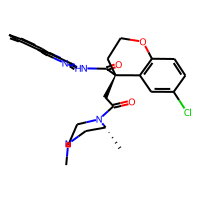
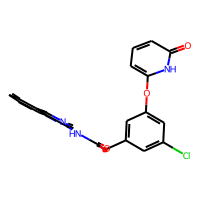
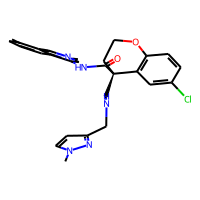
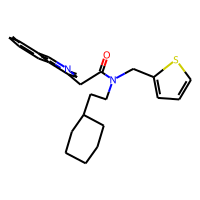
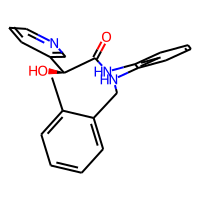
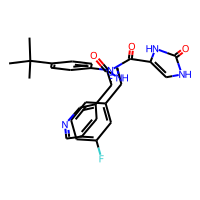
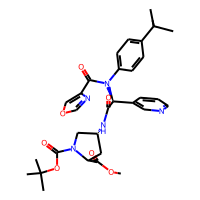
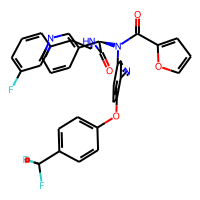
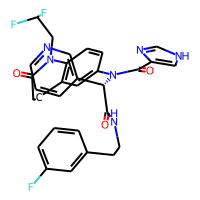
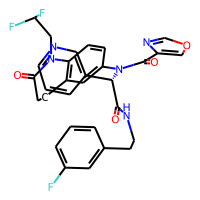

In [6]:
import numpy as np
import pandas as pd
from fresco.model import score_dist


def score_with_kde(kde_model, col_name):
    
    df_docking[col_name] = -100.0
    for i, pair_dist in enumerate(moonshot_pair_distributions):

        score_df_for_this_molecule = pd.DataFrame(columns=pcore_pairs)
        
        for pcore_combination in pcore_pairs:
            kde_for_this_combination = kde_model[pcore_combination]
            pcore_dist = pair_dist[pcore_combination].reshape(
                -1, 1)
            pcore_score = score_dist(kde_for_this_combination, pcore_dist)
            score_df_for_this_molecule.at[0, pcore_combination] = pcore_score

        scores = score_df_for_this_molecule[pcore_pairs].to_numpy().astype(
            float)
        processed_score_for_this_molecule = np.nanmean(scores)
        df_docking.at[i, col_name] = processed_score_for_this_molecule
        
score_with_kde(xray_kde_dict, 'xray_fresco_score')

df_docking
